<a href="https://colab.research.google.com/github/Justinezgh/SBI-Diff-Simulator/blob/u%2FJustinezgh%2Fourmethod/notebooks/Scandal_on_LV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet numpyro dm-haiku==0.0.5 optax

     |████████████████████████████████| 283 kB 38.5 MB/s 
     |████████████████████████████████| 287 kB 83.6 MB/s 
     |████████████████████████████████| 140 kB 90.0 MB/s 
     |████████████████████████████████| 72 kB 751 kB/s 


In [ ]:
!pip install git+https://github.com/Justinezgh/SBI-Diff-Simulator.git#@u/EiffL/Infra

In [ ]:
!pip install chainconsumer

In [ ]:
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
%pylab inline
import arviz as az
az.style.use("arviz-darkgrid")

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import jax
import jax.numpy as jnp
import haiku as hk
import optax
import numpyro
from numpyro.handlers import seed, trace, condition
from functools import partial

In [ ]:
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

In [ ]:
from sbids.tasks import lotka_volterra, get_samples_and_scores
from sbids.models import AffineSigmoidCoupling, ConditionalRealNVP

In [ ]:
from chainconsumer import ChainConsumer

## data

In [ ]:
# truth 
key = jax.random.PRNGKey(0)
lokta_volterra_10 = partial(lotka_volterra, ts=jnp.linspace(0,18.9,5))
lvcond = condition(lokta_volterra_10, {'z':jnp.array([30.0, 1.0])})
(log_probs0, samples0), scores = get_samples_and_scores(lvcond, key, batch_size=1,score_type='conditional')
observation0 = samples0['y']
observation = np.reshape(observation0, (-1,10), order='F')
truth0 = samples0['theta']

In [ ]:
# create data train 
key = jax.random.PRNGKey(10)
(log_probs, samples), score = get_samples_and_scores(lvcond, key, batch_size=5e5, score_type='conditional')
batch = samples['y']
batch = np.reshape(batch, (-1,10), order='F')
mu = samples['theta']


if (batch > 500).any() == True:
  idx = jnp.where(batch > 500)[0]
  batch = jnp.delete(batch, idx, axis=0)
  mu = jnp.delete(mu, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)

if jnp.isnan(batch).any() == True:
  idx = jnp.where(jnp.isnan(batch))[0]
  batch = jnp.delete(batch, idx, axis=0)
  mu = jnp.delete(mu, idx, axis=0)
  score = jnp.delete(score, idx, axis=0)

# normalize data 
scale_theta = (jnp.std(mu, axis =0)/0.02)
shift_theta = jnp.mean(mu/scale_theta, axis = 0)-0.4
normalized_p = (mu/scale_theta) - shift_theta

scale_reg = (jnp.std(batch, axis =0)/0.02)
shift_reg = jnp.mean(batch/scale_reg, axis = 0)-0.4
normalized_reg = (batch/scale_reg) - shift_reg

transformation_params = tfb.Chain([tfb.Scale(scale_theta),tfb.Shift(shift_theta)])
transformation_x = tfb.Chain([tfb.Scale(scale_reg),tfb.Shift(shift_reg)])


# create data stream
batch_size = 1000
ntrain = len(batch)
num_batches = ntrain // batch_size 

def data_stream():
  """
  Creates a data stream with a predifined batch size.
  """
  rng = np.random.RandomState(0)
  while True:
    perm = rng.permutation(ntrain)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size: (i + 1)*batch_size]
      yield normalized_reg[batch_idx], normalized_p[batch_idx], score[batch_idx]

batches = data_stream()

In [ ]:
plt.boxplot([normalized_p[...,0],normalized_p[...,1],normalized_p[...,2],normalized_p[...,3]]);

In [ ]:
plt.boxplot([normalized_reg[...,0],
             normalized_reg[...,1],
             normalized_reg[...,2],
             normalized_reg[...,3],
             normalized_reg[...,4],
             normalized_reg[...,5],
             normalized_reg[...,6],
             normalized_reg[...,7],
             normalized_reg[...,8],
             normalized_reg[...,9]]);

In [ ]:
dist = tfd.Normal(0.5,0.05)
axe = jnp.linspace(0,1,100)
plt.plot(axe,dist.prob(axe))
plt.scatter(normalized_reg[...,1], jnp.zeros(len(normalized_p[...,3])),c='r')

## NF

In [ ]:
from functools import partial

In [ ]:
bijector = partial(AffineSigmoidCoupling, 
                   layers = [260,260,260,260,260,260],
                   n_components = 80, 
                   activation = jax.nn.silu)

NF = partial(ConditionalRealNVP, n_layers = 4, bijector_fn = bijector)

nvp_nd = hk.without_apply_rng(hk.transform(lambda p,x : NF(10)(p).log_prob(x).squeeze()))

nvp_sample_nd = hk.transform(lambda p : NF(10)(p).sample(10000, seed=hk.next_rng_key()))

transformed_log_prob = hk.without_apply_rng(hk.transform(
    lambda p,x:tfd.TransformedDistribution(NF(10)(p), 
                                           transformation_x).log_prob(x)))

In [ ]:
rng_seq = hk.PRNGSequence(5)
params_nd = nvp_nd.init(next(rng_seq),  0.4*jnp.ones([1,4]), 0.4*jnp.ones([1,10]))

In [ ]:
scheduler = optax.exponential_decay(init_value=0.001, transition_steps=2000, decay_rate=0.9, end_value=0.00001)
optimizer = optax.chain(optax.scale_by_adam(), optax.scale_by_schedule(scheduler), optax.scale(-1))
opt_state = optimizer.init(params_nd)

In [ ]:
from tqdm import tqdm

In [ ]:
def loss_fn(params, weight, mu, batch, score):
  log_prob, out = jax.vmap(jax.value_and_grad(lambda theta, x: nvp_nd.apply(params, theta.reshape([1,4]), x.reshape([1,10])).squeeze()))(mu, batch)
  return -jnp.mean(log_prob) + weight * jnp.mean(jnp.sum((out - score)**2, axis=1)) 


@jax.jit
def update(params, opt_state, weight, mu, batch, score):
    """Single SGD update step."""
    loss, grads = jax.value_and_grad(loss_fn)(params, weight, mu, batch, score)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
  
    return loss, new_params, new_opt_state

In [422]:
  # train 
  losses = []
  num_epochs = 70
  weight = 0 
  
  for epochs in tqdm(range(num_epochs)):
    for _ in range(num_batches):
      b,m,s = next(batches)    
      l, params_nd, opt_state = update(params_nd, opt_state,weight, m,  b, s)
      losses.append(l)
      

      if jnp.isnan(l)==True:
        print('NAN')
        break
      
      #params_nd_t = params_nd

    if jnp.isnan(l)==True:
      print('NAN')
      break    


100%|██████████| 20/20 [16:09<00:00, 48.49s/it]


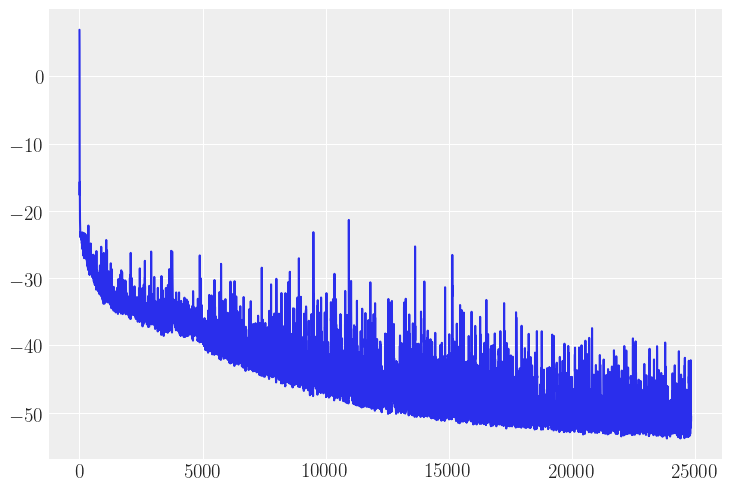

In [335]:
plt.plot(losses)

In [ ]:
sample = nvp_sample_nd.apply(params_nd, rng = next(rng_seq), p = transformation_params.inverse(truth0)*jnp.ones([int(10000),4]))

/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


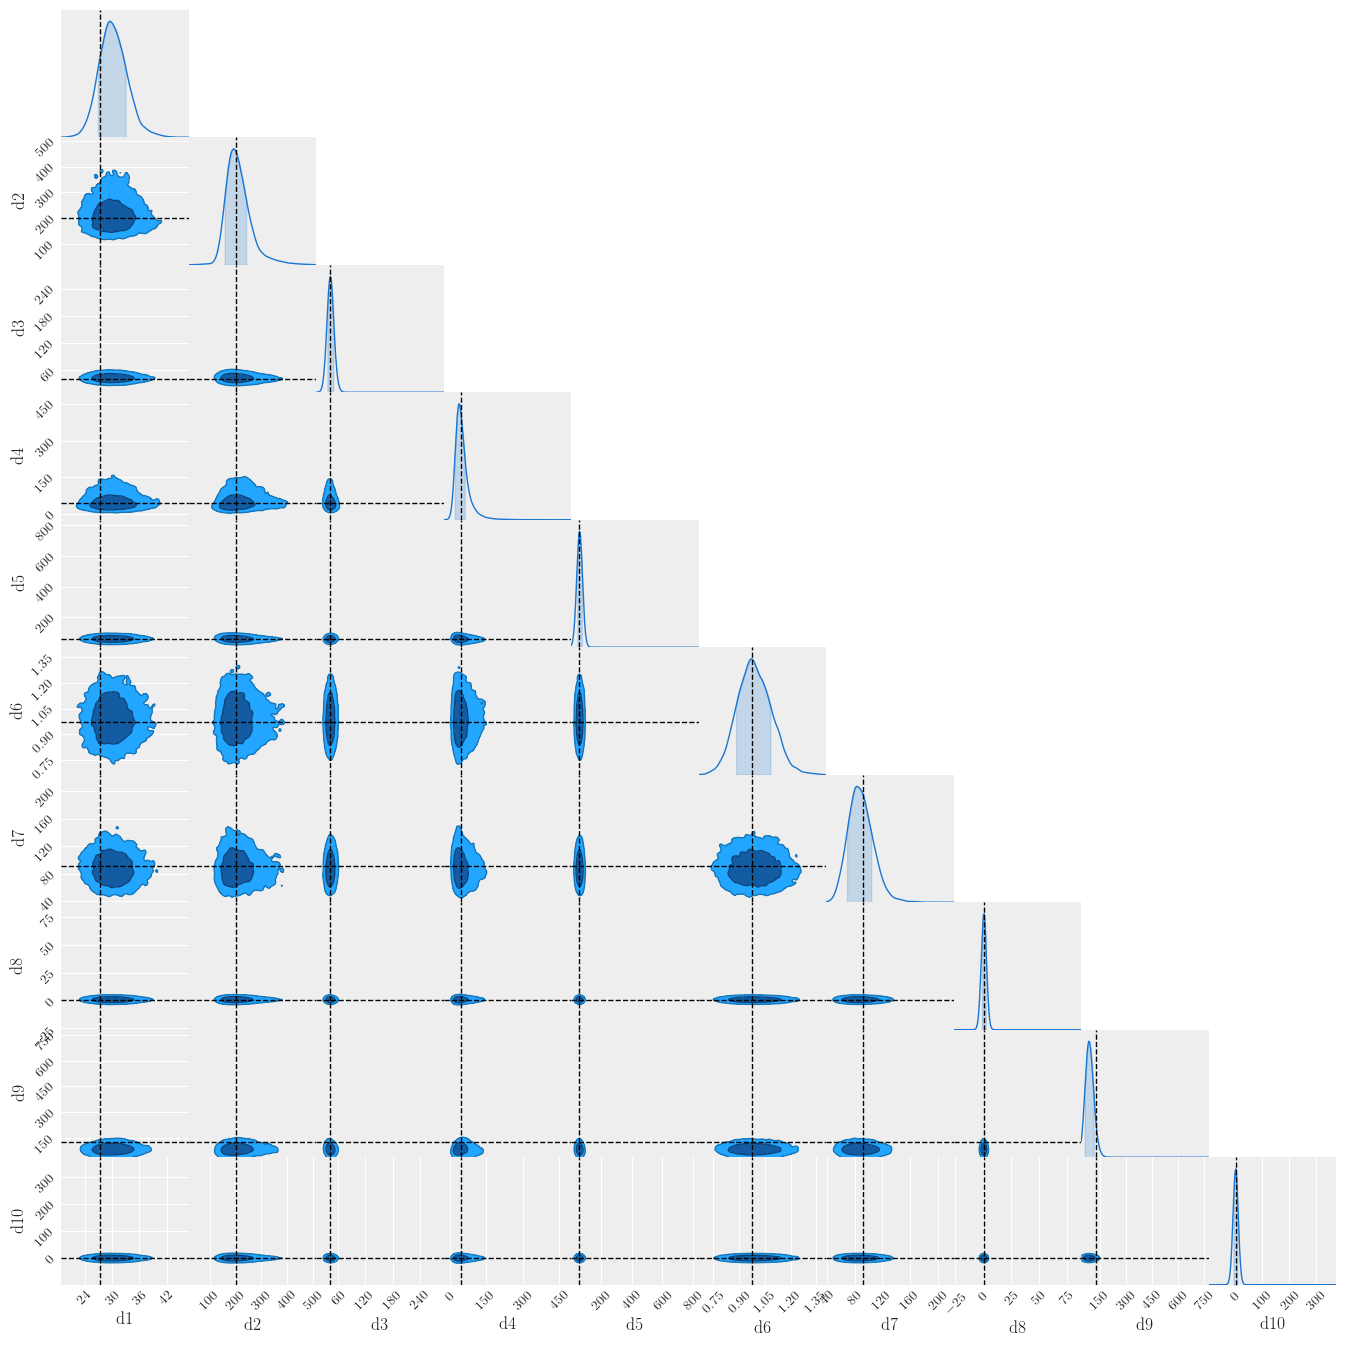

In [440]:
#likelihood
parameters = [r'd1', r'd2', r'd3', r'd4',r'd5', r'd6', r'd7', r'd8',r'd9',r'd10']
c = ChainConsumer()

c.add_chain(transformation_x.forward(sample), parameters=parameters, name="predict")
fig = c.plotter.plot(figsize=[15,15], 
                     truth = [ 27.2423    , 202.24393   ,  42.237514  ,  44.979572  ,
               58.296345  ,   0.9747814 ,  91.78596   ,   0.59529704,
              126.76268   ,   0.4365285 ]
                     )


## mcmc

In [428]:
@jax.jit
def params_log_prob(x,observation):

  prior_params = tfd.TransformedDistribution(tfd.Independent(tfd.LogNormal(jnp.array([-0.125,-3,-0.125,-3]), 0.5*jnp.ones(4)),1),
                                            tfb.Invert(tfb.Softplus()))

  
  log_prob = transformed_log_prob.apply(params_nd,
                              p=transformation_params.inverse(tfb.Softplus()(x)).reshape([1,4]),
                              x=observation.reshape([1,10]))
  #log_prob = nvp_nd.apply(params_nd,transformation_params.inverse(tfb.Softplus()(x)).reshape([1,4]), transformation_x.inverse(observation).reshape([1,10]))
  
  posterior = log_prob
  posterior += prior_params.log_prob(x)
  return posterior

In [429]:
def unnormalized_log_prob(x): 
  return jax.vmap(lambda x: params_log_prob(x,observation))(x).squeeze()

# Initialize the HMC transition kernel.
adaptive_hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1e-3)

# To run 100 chains in parallel
init_state = 0.1*jax.random.normal(jax.random.PRNGKey(1), [100, 4])

@jax.jit
def run_chain():
  # Run the chain (with burn-in).
  samples,is_accepted = tfp.mcmc.sample_chain(
      num_results=int(10000),
      num_burnin_steps=int(5000),
      current_state=init_state,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.is_accepted,
      seed=jax.random.PRNGKey(60))
  return samples,is_accepted
  
samples_hmc,is_accepted = run_chain() 

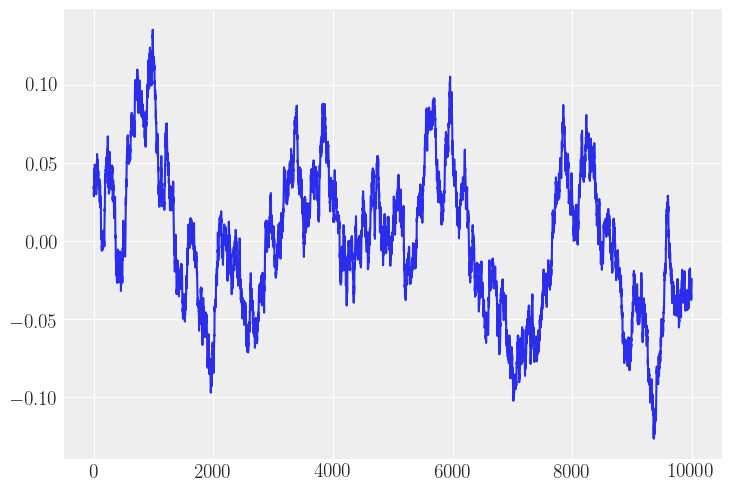

In [430]:
plt.plot(samples_hmc[:,10,2])

In [437]:
sample_nd = samples_hmc[is_accepted][::40]

In [432]:
test_samples_fixed=jnp.load('/content/posterior_z_fixedkey0-4.npy')

/usr/local/lib/python3.7/dist-packages/chainconsumer/plotter.py:943: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.1, wspace=0.05 * spacing, hspace=0.05 * spacing)


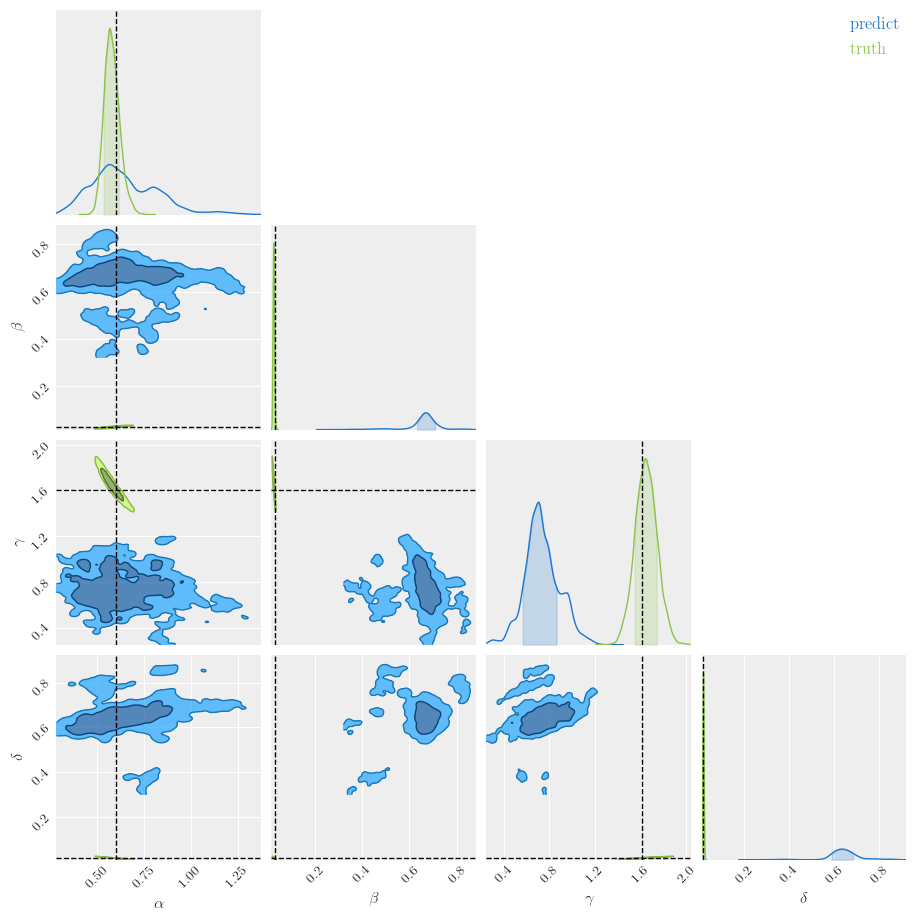

In [439]:
# posterior
parameters = [r'$\alpha$', r'$\beta$', r'$\gamma$', r'$\delta$']
c = ChainConsumer()

c.add_chain(tfb.Softplus()(sample_nd), parameters=parameters, name="predict")
c.add_chain(test_samples_fixed, parameters=parameters, name="truth")
fig = c.plotter.plot(figsize=[10,10], 
                     truth=[0.603503  , 0.03026864, 1.6093055 , 0.01722082],
                     #extents={r'$\alpha$': (0.3,1),
                     #         r'$\beta$':(0,0.08),
                     #         r'$\gamma$':(0.8,2.7),
                     #         r'$\delta$':(0,0.05),}
                     )
